In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *

# Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

# Manual seeding for reproducibility

In [3]:
seed_generators()

# Data

In [4]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Constants & helpers

In [6]:
num_clients = 8
num_classes = 10
rounds = 50
epochs = 5
batch_size = 128

In [7]:
def run_FedAvg(server,clients,device,train_dataset,test_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    """
    run Federated Averaging
    
    Args:
        server
        clients
        device
        train_dataset
        test_dataset
        rounds : number of averaging rounds
        epochs : number of epochs per client per round
        batch_size
        optimizer
        lr : learning rate
        kwargs : optional keyword arguments to pass to the optimizer
        
    Returns:
        model : trained model
        history : training/test loss & accuracy at each epoch
    """
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights() # initialize weights (linear & conv : Kaiming, BN : weights=1 bias =0 )
    
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        
        # train each client
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients) # average client parameters in the sever
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        test_loss, test_acc = evaluate(server.net,test_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - Test loss = {test_loss:.4f}
    - Test accuracy = {test_acc:.4f}
        ''')
        
        history.append([train_loss, test_loss, train_acc, test_acc])
        
    return (server.net,torch.tensor(history))

In [8]:
def save_results(model,path_model,history,path_history):
    """
    save trained model & training history
    """
    torch.save(model.state_dict(), path_model)
    torch.save(history,path_history)

In [9]:
def plot_results(iid_dict,non_iid_dict):
    """
    plot training/test loss & accuracy for all optimizers in iid and non iid settings
    
    Args:
        iid_dict (int) : optimizer parameters and results for the iid setting
        non_iid_dict (int) : optimizer parameters and results for the non-iid setting
    """
    _,axes = plt.subplots(2,2,figsize=(12,12))
    axes = axes.ravel()
    
    # iid
    for name,info_dict in iid_dict.items():
        history = info_dict["history"]
        
        for i,a in enumerate(axes):
            axes[i].plot(range(1,len(history)+1), history[:,i],label=f"{name} iid")
            axes[i].set_xlabel('epoch')
        
    # non-iid
    for name,info_dict in non_iid_dict.items():
        history = info_dict["history"]
        
        for i,a in enumerate(axes):
            axes[i].plot(range(1,len(history)+1), history[:,i],label=f"{name} non-iid")
        
    axes[0].set_ylabel('train loss')
    axes[1].set_ylabel('test loss')
    axes[2].set_ylabel('train accuracy')
    axes[3].set_ylabel('test accuracy')
    
    for a in axes:
        a.legend()
    plt.show()

# IID

In [10]:
# repartition of samples from each class between clients is sampled with dirichlet(alpha)
# for the iid setting, alpha=10e8 ensures each client has the same proportion of each class
partition = partition_by_class(train_dataset)
proportions = generate_proportions(num_clients,num_classes,alpha=10e8)

# assign data samples to each client based on the above proportions
clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
server = Server(model().to(device))

In [11]:
# optimizers and corresponding parameters (chosen after cross validation)
optim_iid_dict = {
    "SGD" : {"optimizer": optim.SGD, "lr" : 1e-1,"kwargs":{}},
    "MSGD" : {"optimizer": optim.SGD, "lr" : 1e-1,"kwargs":{"momentum":0.9}},
    "Adagrad" : {"optimizer": optim.Adagrad, "lr" : 1e-2,"kwargs":{}},
    "Adam" : {"optimizer": optim.Adam, "lr" : 5e-3,"kwargs":{"betas":(0.5,0.95)}},
}

In [12]:
%%time

# for each optimizer and corresponding parameters, run federated averaging
for name,settings in optim_iid_dict.items():
    print("="*25)
    print(f"OPTIMIZER : {name}")
    print(f" - lr={settings['lr']}")
    for n,v in settings['kwargs'].items():
        print(f" - {n}={v}")
    print()
        
    net,history = run_FedAvg(
        server,
        clients,
        device,
        train_dataset,
        test_dataset,
        rounds,
        epochs,
        batch_size,
        settings["optimizer"],
        settings["lr"],
        **settings["kwargs"]
    )
    
    # save model & result
    optim_iid_dict[name]["model"] = net
    optim_iid_dict[name]["history"] = history
    
    print("saving model & training history...")
    save_results(net,f"model_{name}_iid.pt",history,f"history_{name}_iid.pt")
    print("Done.\n")
    
print("="*25)
print(f"RESULTS")
print("="*25)
for name,settings in optim_iid_dict.items():
    print(f"{name} : Accuracy = {settings['history'][-1][-1]:.4f}")

OPTIMIZER : SGD
 - lr=0.1

>>> Round 1 ...
client 1 : Loss = 1.0284, Accuracy = 0.6383
client 2 : Loss = 0.9951, Accuracy = 0.6453
client 3 : Loss = 1.0567, Accuracy = 0.6218
client 4 : Loss = 1.0394, Accuracy = 0.6310
client 5 : Loss = 1.0737, Accuracy = 0.6200
client 6 : Loss = 1.0512, Accuracy = 0.6280
client 7 : Loss = 1.0394, Accuracy = 0.6324
client 8 : Loss = 1.1180, Accuracy = 0.6019

Server :
    - training loss = 1.3347
    - training accuracy = 0.5223
    - Test loss = 1.3769
    - Test accuracy = 0.5078
        
>>> Round 2 ...
client 1 : Loss = 0.6714, Accuracy = 0.7649
client 2 : Loss = 0.7038, Accuracy = 0.7576
client 3 : Loss = 0.7280, Accuracy = 0.7413
client 4 : Loss = 0.7093, Accuracy = 0.7492
client 5 : Loss = 0.7002, Accuracy = 0.7530
client 6 : Loss = 0.7421, Accuracy = 0.7401
client 7 : Loss = 0.7122, Accuracy = 0.7513
client 8 : Loss = 0.7509, Accuracy = 0.7374

Server :
    - training loss = 0.9808
    - training accuracy = 0.6581
    - Test loss = 1.0696
    -

client 3 : Loss = 0.0272, Accuracy = 0.9941
client 4 : Loss = 0.0260, Accuracy = 0.9954
client 5 : Loss = 0.0290, Accuracy = 0.9935
client 6 : Loss = 0.0265, Accuracy = 0.9936
client 7 : Loss = 0.0302, Accuracy = 0.9930
client 8 : Loss = 0.0292, Accuracy = 0.9934

Server :
    - training loss = 0.0811
    - training accuracy = 0.9745
    - Test loss = 0.9185
    - Test accuracy = 0.7633
        
>>> Round 18 ...
client 1 : Loss = 0.0249, Accuracy = 0.9941
client 2 : Loss = 0.0243, Accuracy = 0.9957
client 3 : Loss = 0.0250, Accuracy = 0.9943
client 4 : Loss = 0.0289, Accuracy = 0.9922
client 5 : Loss = 0.0240, Accuracy = 0.9954
client 6 : Loss = 0.0281, Accuracy = 0.9946
client 7 : Loss = 0.0267, Accuracy = 0.9941
client 8 : Loss = 0.0295, Accuracy = 0.9926

Server :
    - training loss = 0.0668
    - training accuracy = 0.9793
    - Test loss = 0.9337
    - Test accuracy = 0.7634
        
>>> Round 19 ...
client 1 : Loss = 0.0326, Accuracy = 0.9910
client 2 : Loss = 0.0212, Accuracy =

client 6 : Loss = 0.0164, Accuracy = 0.9952
client 7 : Loss = 0.0120, Accuracy = 0.9976
client 8 : Loss = 0.0089, Accuracy = 0.9985

Server :
    - training loss = 0.0046
    - training accuracy = 0.9994
    - Test loss = 1.1244
    - Test accuracy = 0.7634
        
>>> Round 34 ...
client 1 : Loss = 0.0153, Accuracy = 0.9960
client 2 : Loss = 0.0229, Accuracy = 0.9923
client 3 : Loss = 0.0150, Accuracy = 0.9963
client 4 : Loss = 0.0096, Accuracy = 0.9974
client 5 : Loss = 0.0227, Accuracy = 0.9936
client 6 : Loss = 0.0103, Accuracy = 0.9968
client 7 : Loss = 0.0183, Accuracy = 0.9944
client 8 : Loss = 0.0144, Accuracy = 0.9963

Server :
    - training loss = 0.0041
    - training accuracy = 0.9996
    - Test loss = 1.1420
    - Test accuracy = 0.7656
        
>>> Round 35 ...
client 1 : Loss = 0.0103, Accuracy = 0.9974
client 2 : Loss = 0.0175, Accuracy = 0.9943
client 3 : Loss = 0.0191, Accuracy = 0.9946
client 4 : Loss = 0.0121, Accuracy = 0.9959
client 5 : Loss = 0.0166, Accuracy =


Server :
    - training loss = 0.0006
    - training accuracy = 1.0000
    - Test loss = 1.2702
    - Test accuracy = 0.7626
        
>>> Round 50 ...
client 1 : Loss = 0.0089, Accuracy = 0.9976
client 2 : Loss = 0.0066, Accuracy = 0.9982
client 3 : Loss = 0.0050, Accuracy = 0.9990
client 4 : Loss = 0.0050, Accuracy = 0.9987
client 5 : Loss = 0.0071, Accuracy = 0.9984
client 6 : Loss = 0.0046, Accuracy = 0.9989
client 7 : Loss = 0.0052, Accuracy = 0.9989
client 8 : Loss = 0.0073, Accuracy = 0.9983

Server :
    - training loss = 0.0005
    - training accuracy = 1.0000
    - Test loss = 1.2757
    - Test accuracy = 0.7632
        
saving model & training history...
Done.

OPTIMIZER : MSGD
 - lr=0.1
 - momentum=0.9

>>> Round 1 ...
client 1 : Loss = 1.2827, Accuracy = 0.5332
client 2 : Loss = 1.3206, Accuracy = 0.5286
client 3 : Loss = 1.3082, Accuracy = 0.5242
client 4 : Loss = 1.2616, Accuracy = 0.5499
client 5 : Loss = 1.3002, Accuracy = 0.5345
client 6 : Loss = 1.3557, Accuracy = 0.

client 1 : Loss = 0.0530, Accuracy = 0.9824
client 2 : Loss = 0.0652, Accuracy = 0.9775
client 3 : Loss = 0.0534, Accuracy = 0.9825
client 4 : Loss = 0.0453, Accuracy = 0.9840
client 5 : Loss = 0.0500, Accuracy = 0.9831
client 6 : Loss = 0.0585, Accuracy = 0.9787
client 7 : Loss = 0.0567, Accuracy = 0.9819
client 8 : Loss = 0.0458, Accuracy = 0.9854

Server :
    - training loss = 0.0461
    - training accuracy = 0.9853
    - Test loss = 0.8672
    - Test accuracy = 0.8106
        
>>> Round 17 ...
client 1 : Loss = 0.0500, Accuracy = 0.9836
client 2 : Loss = 0.0591, Accuracy = 0.9790
client 3 : Loss = 0.0529, Accuracy = 0.9822
client 4 : Loss = 0.0501, Accuracy = 0.9845
client 5 : Loss = 0.0485, Accuracy = 0.9824
client 6 : Loss = 0.0688, Accuracy = 0.9768
client 7 : Loss = 0.0788, Accuracy = 0.9729
client 8 : Loss = 0.0682, Accuracy = 0.9760

Server :
    - training loss = 0.0368
    - training accuracy = 0.9884
    - Test loss = 0.8648
    - Test accuracy = 0.8144
        
>>> Round

client 4 : Loss = 0.0184, Accuracy = 0.9942
client 5 : Loss = 0.0274, Accuracy = 0.9898
client 6 : Loss = 0.0191, Accuracy = 0.9935
client 7 : Loss = 0.0503, Accuracy = 0.9828
client 8 : Loss = 0.0556, Accuracy = 0.9823

Server :
    - training loss = 0.0008
    - training accuracy = 1.0000
    - Test loss = 1.1304
    - Test accuracy = 0.8088
        
>>> Round 33 ...
client 1 : Loss = 0.0224, Accuracy = 0.9918
client 2 : Loss = 0.0049, Accuracy = 0.9989
client 3 : Loss = 0.0643, Accuracy = 0.9789
client 4 : Loss = 0.0138, Accuracy = 0.9956
client 5 : Loss = 0.0159, Accuracy = 0.9937
client 6 : Loss = 0.0129, Accuracy = 0.9957
client 7 : Loss = 0.0102, Accuracy = 0.9968
client 8 : Loss = 0.0124, Accuracy = 0.9946

Server :
    - training loss = 0.0006
    - training accuracy = 0.9999
    - Test loss = 1.1093
    - Test accuracy = 0.8110
        
>>> Round 34 ...
client 1 : Loss = 0.0170, Accuracy = 0.9939
client 2 : Loss = 0.0136, Accuracy = 0.9945
client 3 : Loss = 0.0116, Accuracy =

client 7 : Loss = 0.0184, Accuracy = 0.9937
client 8 : Loss = 0.0017, Accuracy = 0.9994

Server :
    - training loss = 0.0001
    - training accuracy = 1.0000
    - Test loss = 1.2036
    - Test accuracy = 0.8151
        
>>> Round 49 ...
client 1 : Loss = 0.0089, Accuracy = 0.9970
client 2 : Loss = 0.0033, Accuracy = 0.9987
client 3 : Loss = 0.0010, Accuracy = 1.0000
client 4 : Loss = 0.0014, Accuracy = 0.9997
client 5 : Loss = 0.0130, Accuracy = 0.9960
client 6 : Loss = 0.0044, Accuracy = 0.9982
client 7 : Loss = 0.0187, Accuracy = 0.9934
client 8 : Loss = 0.0045, Accuracy = 0.9986

Server :
    - training loss = 0.0001
    - training accuracy = 1.0000
    - Test loss = 1.2340
    - Test accuracy = 0.8133
        
>>> Round 50 ...
client 1 : Loss = 0.0186, Accuracy = 0.9926
client 2 : Loss = 0.0018, Accuracy = 0.9997
client 3 : Loss = 0.0053, Accuracy = 0.9981
client 4 : Loss = 0.0017, Accuracy = 0.9998
client 5 : Loss = 0.0019, Accuracy = 0.9997
client 6 : Loss = 0.0083, Accuracy =

client 8 : Loss = 0.0391, Accuracy = 0.9949

Server :
    - training loss = 0.2288
    - training accuracy = 0.9212
    - Test loss = 0.6672
    - Test accuracy = 0.8123
        
>>> Round 15 ...
client 1 : Loss = 0.0297, Accuracy = 0.9970
client 2 : Loss = 0.0320, Accuracy = 0.9958
client 3 : Loss = 0.0327, Accuracy = 0.9958
client 4 : Loss = 0.0279, Accuracy = 0.9967
client 5 : Loss = 0.0339, Accuracy = 0.9959
client 6 : Loss = 0.0304, Accuracy = 0.9963
client 7 : Loss = 0.0323, Accuracy = 0.9961
client 8 : Loss = 0.0326, Accuracy = 0.9969

Server :
    - training loss = 0.2076
    - training accuracy = 0.9282
    - Test loss = 0.6548
    - Test accuracy = 0.8168
        
>>> Round 16 ...
client 1 : Loss = 0.0267, Accuracy = 0.9976
client 2 : Loss = 0.0289, Accuracy = 0.9974
client 3 : Loss = 0.0296, Accuracy = 0.9976
client 4 : Loss = 0.0268, Accuracy = 0.9979
client 5 : Loss = 0.0298, Accuracy = 0.9971
client 6 : Loss = 0.0306, Accuracy = 0.9960
client 7 : Loss = 0.0280, Accuracy =

client 1 : Loss = 0.0117, Accuracy = 0.9973
client 2 : Loss = 0.0111, Accuracy = 0.9984
client 3 : Loss = 0.0120, Accuracy = 0.9979
client 4 : Loss = 0.0131, Accuracy = 0.9974
client 5 : Loss = 0.0114, Accuracy = 0.9986
client 6 : Loss = 0.0113, Accuracy = 0.9984
client 7 : Loss = 0.0112, Accuracy = 0.9986
client 8 : Loss = 0.0108, Accuracy = 0.9986

Server :
    - training loss = 0.0351
    - training accuracy = 0.9894
    - Test loss = 0.7552
    - Test accuracy = 0.8236
        
>>> Round 32 ...
client 1 : Loss = 0.0099, Accuracy = 0.9982
client 2 : Loss = 0.0119, Accuracy = 0.9984
client 3 : Loss = 0.0130, Accuracy = 0.9971
client 4 : Loss = 0.0103, Accuracy = 0.9979
client 5 : Loss = 0.0091, Accuracy = 0.9987
client 6 : Loss = 0.0094, Accuracy = 0.9989
client 7 : Loss = 0.0110, Accuracy = 0.9987
client 8 : Loss = 0.0109, Accuracy = 0.9982

Server :
    - training loss = 0.0312
    - training accuracy = 0.9908
    - Test loss = 0.7650
    - Test accuracy = 0.8259
        
>>> Round

client 4 : Loss = 0.0078, Accuracy = 0.9981
client 5 : Loss = 0.0085, Accuracy = 0.9982
client 6 : Loss = 0.0076, Accuracy = 0.9984
client 7 : Loss = 0.0102, Accuracy = 0.9973
client 8 : Loss = 0.0087, Accuracy = 0.9974

Server :
    - training loss = 0.0059
    - training accuracy = 0.9987
    - Test loss = 0.9313
    - Test accuracy = 0.8250
        
>>> Round 48 ...
client 1 : Loss = 0.0078, Accuracy = 0.9982
client 2 : Loss = 0.0126, Accuracy = 0.9961
client 3 : Loss = 0.0115, Accuracy = 0.9969
client 4 : Loss = 0.0102, Accuracy = 0.9973
client 5 : Loss = 0.0077, Accuracy = 0.9979
client 6 : Loss = 0.0069, Accuracy = 0.9987
client 7 : Loss = 0.0096, Accuracy = 0.9974
client 8 : Loss = 0.0089, Accuracy = 0.9979

Server :
    - training loss = 0.0049
    - training accuracy = 0.9992
    - Test loss = 0.9394
    - Test accuracy = 0.8275
        
>>> Round 49 ...
client 1 : Loss = 0.0064, Accuracy = 0.9987
client 2 : Loss = 0.0082, Accuracy = 0.9981
client 3 : Loss = 0.0069, Accuracy =

client 5 : Loss = 0.0856, Accuracy = 0.9726
client 6 : Loss = 0.0850, Accuracy = 0.9718
client 7 : Loss = 0.1008, Accuracy = 0.9692
client 8 : Loss = 0.0773, Accuracy = 0.9723

Server :
    - training loss = 0.0898
    - training accuracy = 0.9693
    - Test loss = 0.8520
    - Test accuracy = 0.8285
        
>>> Round 14 ...
client 1 : Loss = 0.1008, Accuracy = 0.9677
client 2 : Loss = 0.0775, Accuracy = 0.9767
client 3 : Loss = 0.0937, Accuracy = 0.9689
client 4 : Loss = 0.0806, Accuracy = 0.9730
client 5 : Loss = 0.0834, Accuracy = 0.9751
client 6 : Loss = 0.0902, Accuracy = 0.9714
client 7 : Loss = 0.0864, Accuracy = 0.9737
client 8 : Loss = 0.0945, Accuracy = 0.9696

Server :
    - training loss = 0.0748
    - training accuracy = 0.9746
    - Test loss = 0.8961
    - Test accuracy = 0.8281
        
>>> Round 15 ...
client 1 : Loss = 0.0991, Accuracy = 0.9695
client 2 : Loss = 0.0691, Accuracy = 0.9768
client 3 : Loss = 0.0827, Accuracy = 0.9760
client 4 : Loss = 0.0751, Accuracy =

client 8 : Loss = 0.0710, Accuracy = 0.9776

Server :
    - training loss = 0.0063
    - training accuracy = 0.9984
    - Test loss = 1.2341
    - Test accuracy = 0.8291
        
>>> Round 30 ...
client 1 : Loss = 0.0802, Accuracy = 0.9761
client 2 : Loss = 0.0788, Accuracy = 0.9781
client 3 : Loss = 0.0713, Accuracy = 0.9802
client 4 : Loss = 0.0730, Accuracy = 0.9779
client 5 : Loss = 0.0565, Accuracy = 0.9824
client 6 : Loss = 0.0627, Accuracy = 0.9812
client 7 : Loss = 0.0643, Accuracy = 0.9827
client 8 : Loss = 0.0727, Accuracy = 0.9797

Server :
    - training loss = 0.0064
    - training accuracy = 0.9984
    - Test loss = 1.2329
    - Test accuracy = 0.8308
        
>>> Round 31 ...
client 1 : Loss = 0.0778, Accuracy = 0.9800
client 2 : Loss = 0.0589, Accuracy = 0.9833
client 3 : Loss = 0.0478, Accuracy = 0.9872
client 4 : Loss = 0.0601, Accuracy = 0.9814
client 5 : Loss = 0.0631, Accuracy = 0.9819
client 6 : Loss = 0.0693, Accuracy = 0.9802
client 7 : Loss = 0.0665, Accuracy =

client 1 : Loss = 0.0506, Accuracy = 0.9859
client 2 : Loss = 0.0465, Accuracy = 0.9861
client 3 : Loss = 0.0721, Accuracy = 0.9817
client 4 : Loss = 0.0579, Accuracy = 0.9862
client 5 : Loss = 0.0548, Accuracy = 0.9860
client 6 : Loss = 0.0560, Accuracy = 0.9872
client 7 : Loss = 0.0581, Accuracy = 0.9839
client 8 : Loss = 0.0542, Accuracy = 0.9851

Server :
    - training loss = 0.0007
    - training accuracy = 0.9999
    - Test loss = 1.5563
    - Test accuracy = 0.8323
        
>>> Round 47 ...
client 1 : Loss = 0.0626, Accuracy = 0.9837
client 2 : Loss = 0.0571, Accuracy = 0.9861
client 3 : Loss = 0.0665, Accuracy = 0.9839
client 4 : Loss = 0.0443, Accuracy = 0.9880
client 5 : Loss = 0.0591, Accuracy = 0.9848
client 6 : Loss = 0.0532, Accuracy = 0.9856
client 7 : Loss = 0.0679, Accuracy = 0.9846
client 8 : Loss = 0.0373, Accuracy = 0.9877

Server :
    - training loss = 0.0006
    - training accuracy = 0.9999
    - Test loss = 1.5745
    - Test accuracy = 0.8352
        
>>> Round

# Non-IID

In [13]:
# repartition of samples from each class between clients is sampled with dirichlet(alpha)
# for the non-iid setting, alpha=0.1 ensures varied data distributions in clients
partition = partition_by_class(train_dataset)
proportions = generate_proportions(num_clients,num_classes,alpha=0.1)

# assign data samples to each client based on the above proportions
clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
server = Server(model().to(device))

In [14]:
# optimizers and corresponding parameters (chosen after cross validation)
optim_non_iid_dict = {
    "SGD" : {"optimizer": optim.SGD, "lr" : 1e-1,"kwargs":{}},
    "MSGD" : {"optimizer": optim.SGD, "lr" : 1e-1,"kwargs":{"momentum":0.5}},
    "Adagrad" : {"optimizer": optim.Adagrad, "lr" : 1e-2,"kwargs":{}},
    "Adam" : {"optimizer": optim.Adam, "lr" : 5e-3,"kwargs":{"betas":(0.9,0.999)}},
}

In [15]:
%%time
# for each optimizer and corresponding parameters, run federated averaging
for name,settings in optim_non_iid_dict.items():
    print("="*25)
    print(f"OPTIMIZER : {name}")
    print(f" - lr={settings['lr']}")
    for n,v in settings['kwargs'].items():
        print(f" - {n}={v}")
    print()
        
    net,history = run_FedAvg(
        server,
        clients,
        device,
        train_dataset,
        test_dataset,
        rounds,
        epochs,
        batch_size,
        settings["optimizer"],
        settings["lr"],
        **settings["kwargs"]
    )
    
    # save model & results
    optim_non_iid_dict[name]["model"] = net
    optim_non_iid_dict[name]["history"] = history
    
    print("saving model & training history...")
    save_results(net,f"model_{name}_niid.pt",history,f"history_{name}_niid.pt")
    print("Done.\n")
    
print("="*25)
print(f"RESULTS")
print("="*25)
for name,settings in optim_non_iid_dict.items():
    print(f"{name} : Accuracy = {settings['history'][-1][-1]:.4f}")

OPTIMIZER : SGD
 - lr=0.1

>>> Round 1 ...
client 1 : Loss = 0.4766, Accuracy = 0.8185
client 2 : Loss = 0.1185, Accuracy = 0.9603
client 3 : Loss = 0.0946, Accuracy = 0.9672
client 4 : Loss = 0.3115, Accuracy = 0.8830
client 5 : Loss = 0.0840, Accuracy = 0.9723
client 6 : Loss = 0.2618, Accuracy = 0.9059
client 7 : Loss = 0.4463, Accuracy = 0.8505
client 8 : Loss = 0.4444, Accuracy = 0.8355

Server :
    - training loss = 1.9803
    - training accuracy = 0.3552
    - Test loss = 2.0123
    - Test accuracy = 0.3404
        
>>> Round 2 ...
client 1 : Loss = 0.3230, Accuracy = 0.8787
client 2 : Loss = 0.0554, Accuracy = 0.9864
client 3 : Loss = 0.0444, Accuracy = 0.9861
client 4 : Loss = 0.2139, Accuracy = 0.9226
client 5 : Loss = 0.0396, Accuracy = 0.9883
client 6 : Loss = 0.1548, Accuracy = 0.9429
client 7 : Loss = 0.2450, Accuracy = 0.9061
client 8 : Loss = 0.2647, Accuracy = 0.9071

Server :
    - training loss = 1.5441
    - training accuracy = 0.5034
    - Test loss = 1.6074
    -

client 3 : Loss = 0.0065, Accuracy = 0.9982
client 4 : Loss = 0.0104, Accuracy = 0.9988
client 5 : Loss = 0.0048, Accuracy = 0.9990
client 6 : Loss = 0.0053, Accuracy = 0.9990
client 7 : Loss = 0.0332, Accuracy = 0.9914
client 8 : Loss = 0.0198, Accuracy = 0.9949

Server :
    - training loss = 0.6854
    - training accuracy = 0.7581
    - Test loss = 1.2109
    - Test accuracy = 0.6278
        
>>> Round 18 ...
client 1 : Loss = 0.0072, Accuracy = 0.9989
client 2 : Loss = 0.0096, Accuracy = 0.9971
client 3 : Loss = 0.0054, Accuracy = 0.9987
client 4 : Loss = 0.0133, Accuracy = 0.9965
client 5 : Loss = 0.0035, Accuracy = 0.9996
client 6 : Loss = 0.0058, Accuracy = 0.9987
client 7 : Loss = 0.0262, Accuracy = 0.9948
client 8 : Loss = 0.0216, Accuracy = 0.9954

Server :
    - training loss = 0.6650
    - training accuracy = 0.7621
    - Test loss = 1.2012
    - Test accuracy = 0.6307
        
>>> Round 19 ...
client 1 : Loss = 0.0061, Accuracy = 0.9989
client 2 : Loss = 0.0097, Accuracy =

client 6 : Loss = 0.0022, Accuracy = 0.9996
client 7 : Loss = 0.0564, Accuracy = 0.9815
client 8 : Loss = 0.0163, Accuracy = 0.9951

Server :
    - training loss = 0.5503
    - training accuracy = 0.8027
    - Test loss = 1.2619
    - Test accuracy = 0.6334
        
>>> Round 34 ...
client 1 : Loss = 0.0244, Accuracy = 0.9919
client 2 : Loss = 0.0076, Accuracy = 0.9980
client 3 : Loss = 0.0032, Accuracy = 1.0000
client 4 : Loss = 0.0060, Accuracy = 0.9991
client 5 : Loss = 0.0027, Accuracy = 0.9992
client 6 : Loss = 0.0018, Accuracy = 0.9999
client 7 : Loss = 0.0098, Accuracy = 0.9993
client 8 : Loss = 0.0120, Accuracy = 0.9979

Server :
    - training loss = 0.5753
    - training accuracy = 0.7952
    - Test loss = 1.2731
    - Test accuracy = 0.6347
        
>>> Round 35 ...
client 1 : Loss = 0.0017, Accuracy = 0.9998
client 2 : Loss = 0.0038, Accuracy = 0.9997
client 3 : Loss = 0.0044, Accuracy = 0.9997
client 4 : Loss = 0.0046, Accuracy = 0.9997
client 5 : Loss = 0.0027, Accuracy =


Server :
    - training loss = 0.4668
    - training accuracy = 0.8302
    - Test loss = 1.2907
    - Test accuracy = 0.6384
        
>>> Round 50 ...
client 1 : Loss = 0.0011, Accuracy = 0.9999
client 2 : Loss = 0.0047, Accuracy = 0.9994
client 3 : Loss = 0.0025, Accuracy = 1.0000
client 4 : Loss = 0.0019, Accuracy = 1.0000
client 5 : Loss = 0.0012, Accuracy = 0.9998
client 6 : Loss = 0.0009, Accuracy = 0.9999
client 7 : Loss = 0.0102, Accuracy = 0.9963
client 8 : Loss = 0.0056, Accuracy = 0.9996

Server :
    - training loss = 0.4728
    - training accuracy = 0.8284
    - Test loss = 1.2970
    - Test accuracy = 0.6403
        
saving model & training history...
Done.

OPTIMIZER : MSGD
 - lr=0.1
 - momentum=0.5

>>> Round 1 ...
client 1 : Loss = 0.5192, Accuracy = 0.7978
client 2 : Loss = 0.1694, Accuracy = 0.9418
client 3 : Loss = 0.1007, Accuracy = 0.9665
client 4 : Loss = 0.4292, Accuracy = 0.8461
client 5 : Loss = 0.0878, Accuracy = 0.9702
client 6 : Loss = 0.2961, Accuracy = 0.

client 1 : Loss = 0.0159, Accuracy = 0.9954
client 2 : Loss = 0.0033, Accuracy = 1.0000
client 3 : Loss = 0.0050, Accuracy = 0.9995
client 4 : Loss = 0.0092, Accuracy = 0.9976
client 5 : Loss = 0.0036, Accuracy = 0.9994
client 6 : Loss = 0.0048, Accuracy = 0.9988
client 7 : Loss = 0.0178, Accuracy = 0.9970
client 8 : Loss = 0.0260, Accuracy = 0.9930

Server :
    - training loss = 0.6518
    - training accuracy = 0.7709
    - Test loss = 1.1564
    - Test accuracy = 0.6475
        
>>> Round 17 ...
client 1 : Loss = 0.0042, Accuracy = 0.9991
client 2 : Loss = 0.0041, Accuracy = 1.0000
client 3 : Loss = 0.0037, Accuracy = 0.9995
client 4 : Loss = 0.0109, Accuracy = 0.9969
client 5 : Loss = 0.0039, Accuracy = 0.9984
client 6 : Loss = 0.0027, Accuracy = 0.9997
client 7 : Loss = 0.0351, Accuracy = 0.9907
client 8 : Loss = 0.0209, Accuracy = 0.9949

Server :
    - training loss = 0.6397
    - training accuracy = 0.7752
    - Test loss = 1.1660
    - Test accuracy = 0.6518
        
>>> Round

client 4 : Loss = 0.0032, Accuracy = 0.9995
client 5 : Loss = 0.0013, Accuracy = 0.9998
client 6 : Loss = 0.0014, Accuracy = 0.9999
client 7 : Loss = 0.0105, Accuracy = 0.9945
client 8 : Loss = 0.0082, Accuracy = 0.9981

Server :
    - training loss = 0.4991
    - training accuracy = 0.8204
    - Test loss = 1.2212
    - Test accuracy = 0.6588
        
>>> Round 33 ...
client 1 : Loss = 0.0008, Accuracy = 1.0000
client 2 : Loss = 0.0020, Accuracy = 0.9997
client 3 : Loss = 0.0019, Accuracy = 0.9997
client 4 : Loss = 0.0033, Accuracy = 0.9997
client 5 : Loss = 0.0015, Accuracy = 0.9996
client 6 : Loss = 0.0021, Accuracy = 0.9995
client 7 : Loss = 0.0118, Accuracy = 0.9967
client 8 : Loss = 0.0163, Accuracy = 0.9947

Server :
    - training loss = 0.4971
    - training accuracy = 0.8217
    - Test loss = 1.2216
    - Test accuracy = 0.6549
        
>>> Round 34 ...
client 1 : Loss = 0.0011, Accuracy = 0.9998
client 2 : Loss = 0.0183, Accuracy = 0.9951
client 3 : Loss = 0.0033, Accuracy =

client 7 : Loss = 0.0277, Accuracy = 0.9882
client 8 : Loss = 0.0079, Accuracy = 0.9985

Server :
    - training loss = 0.4421
    - training accuracy = 0.8422
    - Test loss = 1.2517
    - Test accuracy = 0.6633
        
>>> Round 49 ...
client 1 : Loss = 0.0008, Accuracy = 0.9999
client 2 : Loss = 0.0011, Accuracy = 1.0000
client 3 : Loss = 0.0011, Accuracy = 0.9997
client 4 : Loss = 0.0017, Accuracy = 0.9998
client 5 : Loss = 0.0010, Accuracy = 0.9998
client 6 : Loss = 0.0008, Accuracy = 1.0000
client 7 : Loss = 0.0101, Accuracy = 0.9985
client 8 : Loss = 0.0048, Accuracy = 0.9989

Server :
    - training loss = 0.4284
    - training accuracy = 0.8446
    - Test loss = 1.2650
    - Test accuracy = 0.6573
        
>>> Round 50 ...
client 1 : Loss = 0.0009, Accuracy = 0.9998
client 2 : Loss = 0.0023, Accuracy = 0.9997
client 3 : Loss = 0.0099, Accuracy = 0.9975
client 4 : Loss = 0.0014, Accuracy = 0.9998
client 5 : Loss = 0.0012, Accuracy = 0.9998
client 6 : Loss = 0.0008, Accuracy =

client 8 : Loss = 0.0372, Accuracy = 0.9911

Server :
    - training loss = 1.0316
    - training accuracy = 0.7239
    - Test loss = 1.3025
    - Test accuracy = 0.6558
        
>>> Round 15 ...
client 1 : Loss = 0.0112, Accuracy = 0.9987
client 2 : Loss = 0.0127, Accuracy = 0.9980
client 3 : Loss = 0.0215, Accuracy = 0.9957
client 4 : Loss = 0.0235, Accuracy = 0.9960
client 5 : Loss = 0.0041, Accuracy = 0.9994
client 6 : Loss = 0.0056, Accuracy = 0.9995
client 7 : Loss = 0.0659, Accuracy = 0.9738
client 8 : Loss = 0.0351, Accuracy = 0.9920

Server :
    - training loss = 1.0440
    - training accuracy = 0.7271
    - Test loss = 1.3229
    - Test accuracy = 0.6555
        
>>> Round 16 ...
client 1 : Loss = 0.0120, Accuracy = 0.9977
client 2 : Loss = 0.0141, Accuracy = 0.9962
client 3 : Loss = 0.0196, Accuracy = 0.9955
client 4 : Loss = 0.0246, Accuracy = 0.9940
client 5 : Loss = 0.0051, Accuracy = 0.9994
client 6 : Loss = 0.0054, Accuracy = 0.9994
client 7 : Loss = 0.0633, Accuracy =

client 1 : Loss = 0.0060, Accuracy = 0.9988
client 2 : Loss = 0.0077, Accuracy = 0.9983
client 3 : Loss = 0.0125, Accuracy = 0.9967
client 4 : Loss = 0.0138, Accuracy = 0.9967
client 5 : Loss = 0.0203, Accuracy = 0.9955
client 6 : Loss = 0.0025, Accuracy = 0.9996
client 7 : Loss = 0.0308, Accuracy = 0.9915
client 8 : Loss = 0.0085, Accuracy = 0.9985

Server :
    - training loss = 0.9101
    - training accuracy = 0.7692
    - Test loss = 1.4015
    - Test accuracy = 0.6729
        
>>> Round 32 ...
client 1 : Loss = 0.0034, Accuracy = 0.9998
client 2 : Loss = 0.0054, Accuracy = 0.9991
client 3 : Loss = 0.0280, Accuracy = 0.9945
client 4 : Loss = 0.0088, Accuracy = 0.9983
client 5 : Loss = 0.0068, Accuracy = 0.9985
client 6 : Loss = 0.0022, Accuracy = 0.9998
client 7 : Loss = 0.0664, Accuracy = 0.9784
client 8 : Loss = 0.0072, Accuracy = 1.0000

Server :
    - training loss = 0.9047
    - training accuracy = 0.7723
    - Test loss = 1.4124
    - Test accuracy = 0.6691
        
>>> Round

client 4 : Loss = 0.0110, Accuracy = 0.9972
client 5 : Loss = 0.0009, Accuracy = 1.0000
client 6 : Loss = 0.0017, Accuracy = 0.9997
client 7 : Loss = 0.0159, Accuracy = 0.9955
client 8 : Loss = 0.0152, Accuracy = 0.9939

Server :
    - training loss = 0.8044
    - training accuracy = 0.7946
    - Test loss = 1.4799
    - Test accuracy = 0.6694
        
>>> Round 48 ...
client 1 : Loss = 0.0033, Accuracy = 0.9993
client 2 : Loss = 0.0098, Accuracy = 0.9968
client 3 : Loss = 0.0365, Accuracy = 0.9919
client 4 : Loss = 0.0257, Accuracy = 0.9940
client 5 : Loss = 0.0010, Accuracy = 1.0000
client 6 : Loss = 0.0018, Accuracy = 0.9997
client 7 : Loss = 0.0196, Accuracy = 0.9952
client 8 : Loss = 0.0061, Accuracy = 0.9981

Server :
    - training loss = 0.7963
    - training accuracy = 0.7973
    - Test loss = 1.4786
    - Test accuracy = 0.6767
        
>>> Round 49 ...
client 1 : Loss = 0.0037, Accuracy = 0.9991
client 2 : Loss = 0.0058, Accuracy = 0.9991
client 3 : Loss = 0.0461, Accuracy =

client 5 : Loss = 0.0108, Accuracy = 0.9969
client 6 : Loss = 0.0288, Accuracy = 0.9901
client 7 : Loss = 0.0577, Accuracy = 0.9792
client 8 : Loss = 0.0400, Accuracy = 0.9884

Server :
    - training loss = 1.0334
    - training accuracy = 0.7216
    - Test loss = 1.3935
    - Test accuracy = 0.6500
        
>>> Round 14 ...
client 1 : Loss = 0.0482, Accuracy = 0.9834
client 2 : Loss = 0.0205, Accuracy = 0.9939
client 3 : Loss = 0.0359, Accuracy = 0.9882
client 4 : Loss = 0.0364, Accuracy = 0.9896
client 5 : Loss = 0.0164, Accuracy = 0.9949
client 6 : Loss = 0.0328, Accuracy = 0.9888
client 7 : Loss = 0.0456, Accuracy = 0.9844
client 8 : Loss = 0.0289, Accuracy = 0.9897

Server :
    - training loss = 1.0015
    - training accuracy = 0.7255
    - Test loss = 1.3742
    - Test accuracy = 0.6478
        
>>> Round 15 ...
client 1 : Loss = 0.0250, Accuracy = 0.9912
client 2 : Loss = 0.0227, Accuracy = 0.9916
client 3 : Loss = 0.0222, Accuracy = 0.9937
client 4 : Loss = 0.0613, Accuracy =

client 8 : Loss = 0.0251, Accuracy = 0.9928

Server :
    - training loss = 0.8837
    - training accuracy = 0.7630
    - Test loss = 1.4321
    - Test accuracy = 0.6574
        
>>> Round 30 ...
client 1 : Loss = 0.0286, Accuracy = 0.9914
client 2 : Loss = 0.0180, Accuracy = 0.9962
client 3 : Loss = 0.0128, Accuracy = 0.9977
client 4 : Loss = 0.0384, Accuracy = 0.9855
client 5 : Loss = 0.0227, Accuracy = 0.9938
client 6 : Loss = 0.0208, Accuracy = 0.9928
client 7 : Loss = 0.0388, Accuracy = 0.9855
client 8 : Loss = 0.0215, Accuracy = 0.9939

Server :
    - training loss = 1.0038
    - training accuracy = 0.7555
    - Test loss = 1.5800
    - Test accuracy = 0.6512
        
>>> Round 31 ...
client 1 : Loss = 0.0207, Accuracy = 0.9918
client 2 : Loss = 0.0197, Accuracy = 0.9939
client 3 : Loss = 0.0114, Accuracy = 0.9970
client 4 : Loss = 0.0141, Accuracy = 0.9957
client 5 : Loss = 0.0041, Accuracy = 0.9996
client 6 : Loss = 0.0158, Accuracy = 0.9949
client 7 : Loss = 0.0539, Accuracy =

client 1 : Loss = 0.0253, Accuracy = 0.9914
client 2 : Loss = 0.0177, Accuracy = 0.9942
client 3 : Loss = 0.0138, Accuracy = 0.9957
client 4 : Loss = 0.0099, Accuracy = 0.9974
client 5 : Loss = 0.0037, Accuracy = 0.9988
client 6 : Loss = 0.0206, Accuracy = 0.9949
client 7 : Loss = 0.0421, Accuracy = 0.9900
client 8 : Loss = 0.0129, Accuracy = 0.9964

Server :
    - training loss = 0.8877
    - training accuracy = 0.7863
    - Test loss = 1.5955
    - Test accuracy = 0.6666
        
>>> Round 47 ...
client 1 : Loss = 0.0263, Accuracy = 0.9928
client 2 : Loss = 0.0173, Accuracy = 0.9948
client 3 : Loss = 0.0118, Accuracy = 0.9980
client 4 : Loss = 0.0121, Accuracy = 0.9960
client 5 : Loss = 0.0034, Accuracy = 0.9990
client 6 : Loss = 0.0217, Accuracy = 0.9945
client 7 : Loss = 0.0346, Accuracy = 0.9881
client 8 : Loss = 0.0412, Accuracy = 0.9873

Server :
    - training loss = 0.9152
    - training accuracy = 0.7838
    - Test loss = 1.5899
    - Test accuracy = 0.6692
        
>>> Round

# Results

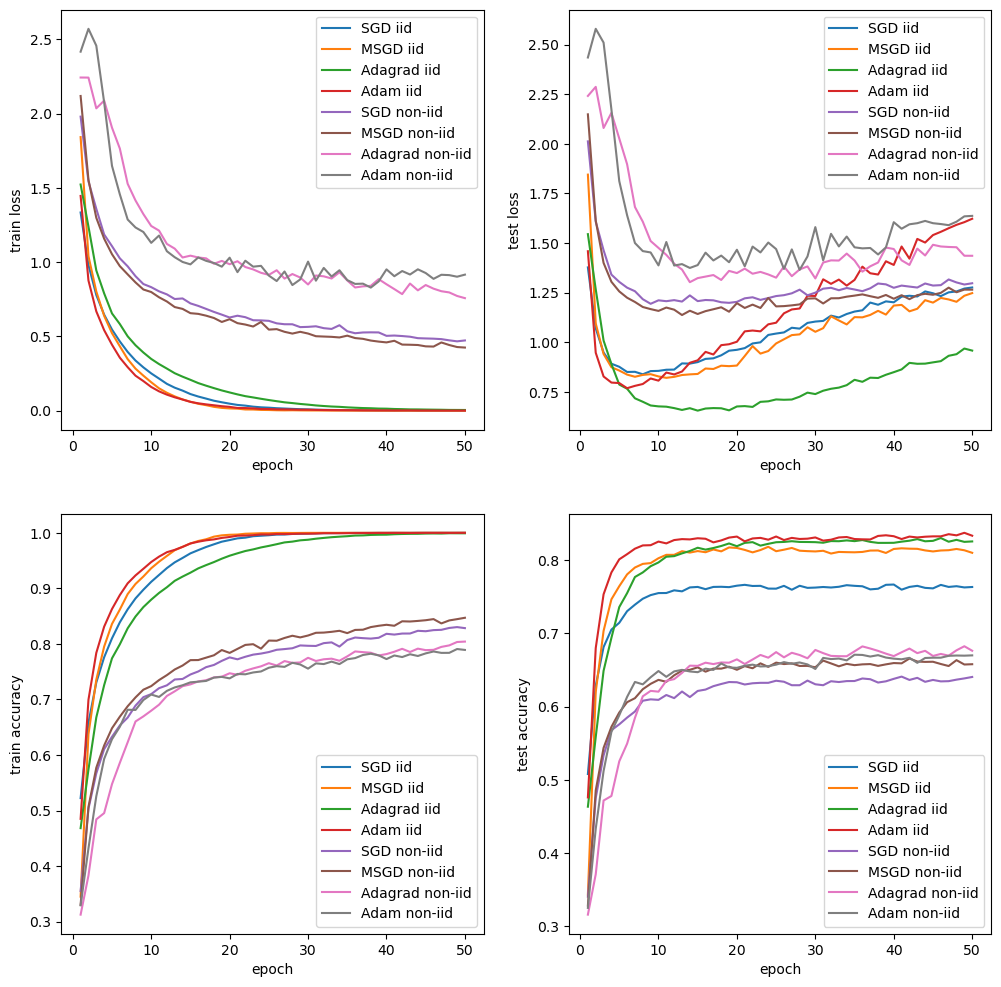

In [16]:
plot_results(optim_iid_dict,optim_non_iid_dict)